In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Hot Streak

스포츠에서 선수가 어느 기간동안 꾸준히 좋은 퍼포먼스를 보여주는 것을 'Hot Hand' / 'Hot Streak' 효과라고 한다.    
    
야구에서도 어떤 타자가 최근 10경기 타율이 5할이 넘는다면, '방망이에 불 붙었다' 혹은 '분위기 탔다'라고 표현한다. 선수의 컨디션에 따라 특정 구간에 좋은 퍼포먼스를 보여준다고 생각하기 때문이다. **정말 이런 Hot Streak 상태는 선수의 특성일까? 아니면 단순한 우연일까?**   
   
선수들이 'Hot Streak' 효과 같이 연속적으로 좋은 결과를 만들어내는 것이 그 선수의 특성인지, 혹은 단순한 우연인지 확인해보았다. 21시즌 MLB의 스탯캐스트 데이터를 이용하였고, 21시즌에 성공적인 결과를 이루어낸 Matt Olson 타자의 기록을 살펴보았다.

### [Method 1: Moving Average](#ma)
   
### [Method 2: Streak Length](#sl)

### [Conclusion](#cl)

----

In [2]:
mlb21=pyb.statcast('2021-04-01', '2021-10-03')

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [02:50<00:00,  1.09it/s]


In [3]:
on_base = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch']
mlb21['on_base'] = np.where(mlb21['events'].isin(on_base), 1, 0)
mlb21['sac_bunt'] = np.where((mlb21['events']=='sac_bunt')|(mlb21['events']=='sac_bunt_double_play'), 1, 0)

In [4]:
df = mlb21.groupby(['game_date', 'batter']).agg({'events': 'count', 'on_base': 'sum', 'sac_bunt': 'sum'}).reset_index().rename(columns={'events': 'pa'})
batter_ids = np.array(mlb21['batter'].unique())
name_data = pyb.playerid_reverse_lookup(batter_ids, key_type='mlbam').rename(columns={'key_mlbam': 'batter'})
name_data['player'] = name_data['name_first'] +' '+ name_data['name_last']
name_data['player'] = name_data['player'].str.title()
player_df = pd.merge(name_data[['player', 'batter']], df, on='batter')

Gathering player lookup table. This may take a moment.


----

<a id="ma"></a>
# Method 1: Moving Average

Moving Average란 데이터를 단위 길이 당 평균을 연속적으로 구해 나열하는 것을 의미한다. 예를 들면, 먼저 1-10경기의 평균 출루율을 구하고 다음엔 2-11경기의 평균 출루율, 3-12경기의 평균 출루율, 4-13경기의 평균 출루율을 연속적으로 구하는 것이다. 그래서 각 게임 당 출루율 대신, 10경기의 평균 출루율의 변화를 확인할 수 있다.   
   
여기서는 Matt Olson 선수의 출루율 10경기 moving average를 확인해보았다. 이를 통해 10경기 평균 OBP가 크다면, Olson선수의 Hot Streak 상태를 확인할 수 있고, 반대로 낮다면 Cold Streak 상태를 확인할 수 있다. 한 시즌에 얼마나 많이, 자주 Streak 상태가 나타나는지 확인하고, 이것이 Olson 선수의 특성인지 확인해보았다.   
    
Streak이 Olson 선수의 특성인지 확인하기 위해 가상의 선수를 생성하여 시뮬레이션을 돌려보고 데이터를 비교해보았다. 가상의 선수는 매 타석 출루 확률이 0.371(Olson 선수의 시즌 평균 OBP)이다. 가상의 선수는 실제 선수와 다르게 컨디션이나 부상이라는 것이 없기 때문에, 항상 출루 확률 0.371을 정확히 유지한다. 어느 시점에 좋은 퍼포먼스를 보여주는 Streak이 선수의 특성이라면, 가상의 선수는 moving average가 큰 변화없이 적정선 유지될 것이다. 반대로 Streak이 단순히 운에 의한 거라면, 가상의 선수 또한 moving average에서 Streak을 보여줄 것이다. 이를 확인해보았다.

## 1-1. Matt Olson

In [5]:
stat_21 = pyb.batting_stats(2021)
olson_stat = stat_21[stat_21['IDfg']==14344][['Season', 'Name', 'Team', 'AB', 'PA', 'H', 'AVG', 'OBP']]
olson_stat

,Season,Name,Team,AB,PA,H,AVG,OBP
16,2021,Matt Olson,OAK,565,673,153,0.271,0.371


In [6]:
olson_obp = 0.371
olson = player_df[player_df['player']=='Matt Olson']
olson

,player,batter,game_date,pa,on_base,sac_bunt
33096,Matt Olson,621566,2021-04-01,4,1,0
33097,Matt Olson,621566,2021-04-02,5,3,0
33098,Matt Olson,621566,2021-04-03,4,3,0
33099,Matt Olson,621566,2021-04-04,4,0,0
33100,Matt Olson,621566,2021-04-05,4,1,0
...,...,...,...,...,...,...
33246,Matt Olson,621566,2021-09-28,4,1,0
33247,Matt Olson,621566,2021-09-29,4,1,0
33248,Matt Olson,621566,2021-10-01,5,1,0
33249,Matt Olson,621566,2021-10-02,5,2,0


In [7]:
olson['pa_10'] = olson['pa'].rolling(10).sum()
olson['on_base_10'] = olson['on_base'].rolling(10).sum()
olson['sac_bunt_10'] = olson['sac_bunt'].rolling(10).sum()
olson['moving_obp'] = olson['on_base_10']/(olson['pa_10'])
olson.index = np.arange(1, len(olson)+1)

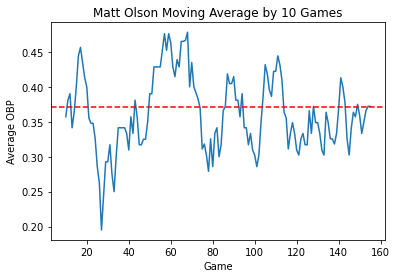

In [8]:
plt.plot(olson['moving_obp'])
plt.axhline(olson_obp, color='red', linestyle='--')
plt.xlabel('Game')
plt.ylabel('Average OBP')
plt.title('Matt Olson Moving Average by 10 Games')
plt.show()

moving average 그래프를 확인해보면, Matt Olson 선수는 60번째 경기 근처에서 10경기 평균 출루율이 5할을 웃도는 Hot Streak 상태임을 확인할 수 있다. 반면에 10경기 평균 출루율이 2할대로 내려가는 Cold Streak 또한 확인할 수 있었고, 25경기 째에는 10경기 평균 출루율이 2할까지 떨어지는 것을 확인할 수 있었다.   
    
Matt Olson 선수는 25경기 근처에서 컨디션이 좋지 않아서 Cold Streak이 되었던걸까? 60경기 근처에서는 타격감이 살아나 Hot Streak 상태가 된 것일까? 아니면 단순한 우연일까?   
   
가상의 선수 출루율 시뮬레이션을 통해 비교해보았다.

## 1-2. Hypothesis Player

가상의 선수의 출루율을 시뮬레이션 해보았다. 이 가상의 선수는 매 타석 0.371(Matt Olson 선수의 시즌 평균 출류율) 출루율의 확률을 가진다. 이 가상의 선수가 Olson 선수와 같은 155경기, 각 경기당 4타석을 수행한다고 하였을 때, 10경기 당 평균 출루율을 moving average로 표현하였다.   

가상의 선수는 컨디션, 부상, 타격감, 흐름이라는 것이 없이 오로지 확률 0.371을 가지고 출루한다. 이 가상의 선수는 Hot Streak, Cold Streak이 존재할까? 아니면 큰 Streak 없이 고정확률 0.371 근처에서 moving average가 일정하게 형성될까?

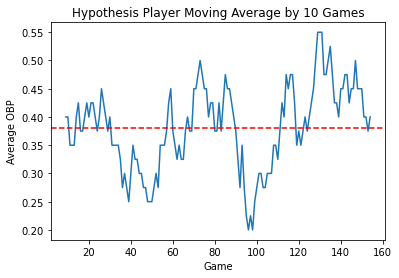

In [16]:
nums = np.random.choice([1, 0], size=155*4, p=[.371, 1-0.371])
hy_p = pd.DataFrame(nums, columns=['on_base'])
hy_p_obp = hy_p.groupby(np.arange(len(hy_p))//4).mean()
hy_p_obp['obp_10'] = hy_p_obp['on_base'].rolling(10).mean()

plt.plot(hy_p_obp['obp_10'])
plt.axhline(hy_p_obp['on_base'].mean(), color='red', linestyle='--')
plt.xlabel('Game')
plt.ylabel('Average OBP')
plt.title('Hypothesis Player Moving Average by 10 Games')
plt.show()

모든 타석 0.371의 출루율을 가지는 가상의 선수 moving average 그래프이다. 놀랍게도, 실제 Matt Olson 선수보다 더 큰 Streak이 존재하는 것을 확인할 수 있었다. 0.2까지 떨어지는 Cold Streak과 0.55 근처까지 올라가는 Hot Streak이 존재하였다.

혹시 우연히 이런 결과가 나온 것일지를 확인하기 위해 여러번 시뮬레이션을 해보았다.

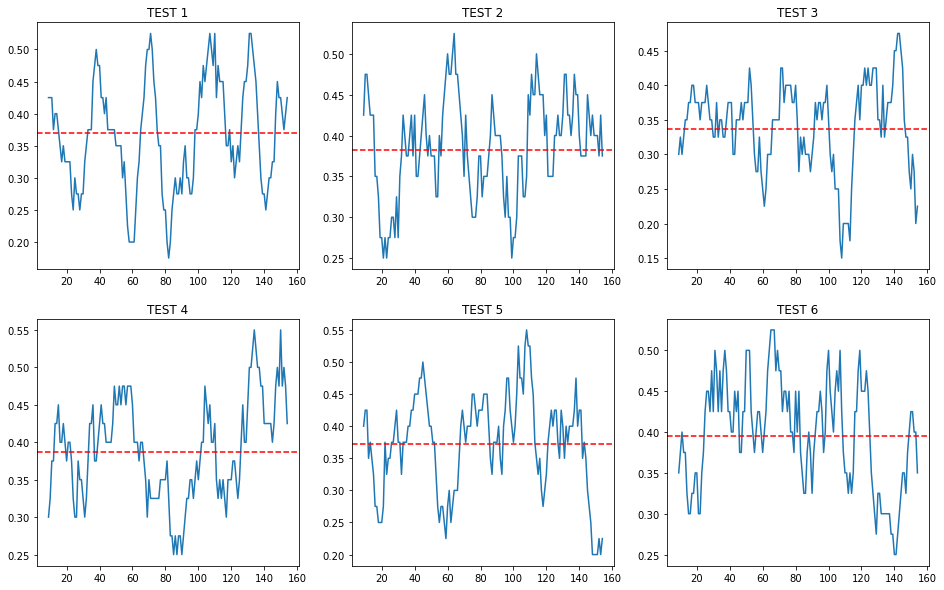

In [17]:
plt.figure(figsize=(16, 10))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    nums = np.random.choice([1, 0], size=155*4, p=[.371, 1-0.371])
    hy_p = pd.DataFrame(nums, columns=['on_base'])
    hy_p_obp = hy_p.groupby(np.arange(len(hy_p))//4).mean()
    hy_p_obp['obp_10'] = hy_p_obp['on_base'].rolling(10).mean()

    ax.plot(hy_p_obp['obp_10'])
    plt.axhline(hy_p_obp['on_base'].mean(), color='red', linestyle='--')
    plt.title('TEST '+str(i+1))

plt.show()

매 시뮬레이션마다 Streak이라고 부를 수 있는 큰 골짜기들이 형성되었다. 항상 일정한 0.371의 출루율을 가지는 가상의 선수 또한 Streak이 생기는 것이 확인되었다.

----

<a id="sl"></a>
# Method 2: Streak Length

Streak Length는 좋은(혹은 나쁜) 퍼포먼스를 보여준 경기들의 연속값이다. Matt Olson 선수의 매 경기 출루율을 시즌 평균 출루율 0.371과 비교하여 더 높으면 'Hot', 낮으면 'Cold'를 기록하였다. 그 다음 'Hot'과 'Cold'가 얼마나 연속적으로 나타났는지를 측정한 것이 Streak Length이다. 이 Streak Length 값의 Max값을 계산하여 그 값이 크면 그 선수는 Hot/Cold Streak 효과가 있다고 할 수 있다.   
또한, Streak의 개수도 의미가 있다. Streak의 개수가 작다는 것은 그만큼 Hot/Cold가 변하지 않고 그대로 유지되었던 기간이 길었다는 것을 의미하기 때문에 Streak 효과라고 할 수 있다.
   
예를 들어, 아래는 Matt Olson 선수의 시즌 개막 후 첫 10경기 기록이다. 'Hot'을 H로, 'Cold'를 C로 적어보면 [C, H, H, C, C, C, H, C, C, H]을 기록하였다. 여기서 H의 Streak Length Max 값은 2(2,3 경기), C의 Streak Length Max 값은 3(4,5,6 경기)이다. Streak 개수는 C/HH/CCC/H/CC/H 로 구분하여 총 6개이다.   
   
Matt Olson 선수의 시즌 Streak length 최대값과 개수를 계산하여 이것이 통계적으로 일반적인 것인지 아니면 Olson 선수의 특성이라 할 수 있는지 확인해보았다.

In [18]:
olson['obp'] = olson['on_base']/(olson['pa']-olson['sac_bunt'])
olson['hot/cold'] = np.where(olson['obp']>=olson_obp, 'Hot', 'Cold')
olson_hot_cold = olson[['player', 'game_date', 'obp', 'hot/cold']]
olson_hot_cold.head(10)

,player,game_date,obp,hot/cold
1,Matt Olson,2021-04-01,0.25,Cold
2,Matt Olson,2021-04-02,0.60,Hot
3,Matt Olson,2021-04-03,0.75,Hot
4,Matt Olson,2021-04-04,0.00,Cold
5,Matt Olson,2021-04-05,0.25,Cold
6,Matt Olson,2021-04-08,0.00,Cold
7,Matt Olson,2021-04-09,0.50,Hot
8,Matt Olson,2021-04-10,0.25,Cold
9,Matt Olson,2021-04-12,0.25,Cold
10,Matt Olson,2021-04-15,0.60,Hot


## 2-1. Matt Olson

In [12]:
olson_hot_cold['hot'] = np.where(olson_hot_cold['hot/cold']=='Hot',True,False)
olson_hot_cold['cold'] = np.where(olson_hot_cold['hot/cold']=='Cold',True,False)

In [13]:
h = olson_hot_cold['hot'].values
c = olson_hot_cold['cold'].values
h_streak = np.bincount((~h).cumsum()[h])
c_streak = np.bincount((~c).cumsum()[c])

In [14]:
{'Max_Hot_Streak': h_streak.max(), 'Max_Cold_Streak': c_streak.max()}

{'Max_Hot_Streak': 6, 'Max_Cold_Streak': 5}

In [19]:
{'Total_Streak_Count':len(h_streak[h_streak!=0])+len(c_streak[c_streak!=0])}

{'Total_Streak_Count': 75}

Matt Olson 선수의 Streak Count는 총 75개가 계산하였고, Hot Streak의 최대값은 6, Cold Streak의 최대값은 5가 계산되었다. 이 수치들이 평균 출루율 0.371의 가상의 선수의 데이터와 어떤 차이를 가지는지 확인해보았다.

## 2-2. Hypothesis Player

In [64]:
hot_max=[]
cold_max=[]
streak_count = []
for _ in range(1000):
    nums_ = np.random.choice([1, 0], size=155*4, p=[.371, 1-0.371])
    hy_p_ = pd.DataFrame(nums_, columns=['on_base'])

    hy_p_obp_ = hy_p_.groupby(np.arange(len(hy_p_))//4).mean()
    hy_p_obp_['hot/cold'] = np.where(hy_p_obp_['on_base']>=olson_obp, 'Hot', 'Cold')
    hy_p_obp_['hot'] = np.where(hy_p_obp_['hot/cold']=='Hot',True,False)
    hy_p_obp_['cold'] = np.where(hy_p_obp_['hot/cold']=='Cold',True,False)

    hh = hy_p_obp_['hot'].values
    ch = hy_p_obp_['cold'].values
    h_streak_h = np.bincount((~hh).cumsum()[hh])
    c_streak_h = np.bincount((~ch).cumsum()[ch])
    
    Max_Hot_Streak = h_streak_h.max()
    Max_Cold_Streak = c_streak_h.max()
    count = len(h_streak_h[h_streak_h!=0])+len(c_streak_h[c_streak_h!=0])
    
    hot_max.append(Max_Hot_Streak)
    cold_max.append(Max_Cold_Streak)
    streak_count.append(count)

d = {'hot_max': hot_max, 'cold_max': cold_max, 'streak_count': streak_count}
streak_length = pd.DataFrame(data=d)

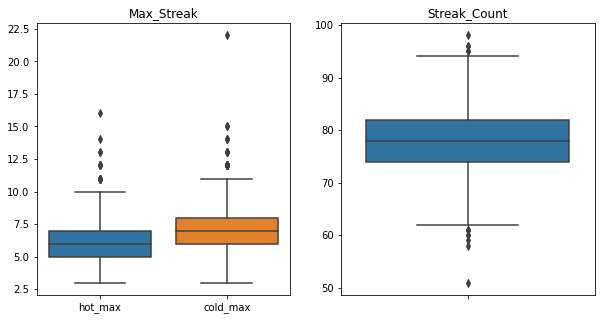

In [65]:
df_melted = pd.melt(streak_length[['hot_max', 'cold_max']])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=df_melted, x='variable', y='value')
plt.title('Max_Streak')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
sns.boxplot(y=streak_length['streak_count'])
plt.title('Streak_Count')
plt.ylabel('')

plt.show()

1000번의 시뮬레이션을 통해 Hot Streak의 최대값, Cold Streak의 최대값, 그리고 Streak Count의 분포를 Box Plot으로 확인해보았다. 0.371의 평균 출루율을 가지는 가상의 선수는 Hot Streak의 최대값이 평균적으로 6-7의 값을 가졌고, Cold Streak은 7정도의 값을 가졌다. 이는 Matt Olson 선수와 크게 차이가 없는 수치이기 때문에 Olson 선수의 Streak 최대값은 통계적으로 있을 수 있는 일이라고 생각할 수 있다. Streak Count 또한 가상의 선수 시뮬레이션의 평균 수치는 약 77-78정도이기 때문에 이 또한 Olson 선수와 큰 차이가 없다.

----

<a id="cl"></a>
# Conclusion

'Hot Hand'/'Hot Streak'이 선수의 특성인가에 대해서 분석해보았다. 가상의 선수의 시뮬레이션 기록을 통계적으로 바라보았을때, 항상 일정한 출루율을 가진다고 하더라도 Streak이 존재하는 것을 확인하였다. 이를 통해 선수들의 일시적인 Streak 효과는 선수의 특성이 아닌 단순한 우연으로 발생한 것이라고 해석할 수 있다.

당연하지만 야구는 사람이 하는 것이기 때문에 선수의 기분, 컨디션 등 여러 요인으로 인해 타격감이 일시적으로 좋아져서 Hot Hand/Hot Streak 효과가 나타날 수 있다. 하지만 이런 Streak 효과가 나타났다고 해서 반드시 그 선수의 타격감이 좋아졌다고 해석하기는 어려워보인다. 반대로 일시적인 Cold Streak 효과가 나타나더라도 타격감이 나빠졌다고 해석하기에는 무리가 있어보인다.

----

### Reference

Jim Albert, *Teaching Statistics using Baseball* (American Mathematical Society), 2017